In [1]:
from run_agent import RunAgent
from agent import Agent
from trading_env import TradingEnv
from memory import Transition
import torch
from torch import nn
import matplotlib.pyplot as plt
import copy
import pandas as pd
import yfinance as yf
import math
from utilis import save_data_structure

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ModuleNotFoundError: No module named 'run_agent'

In [123]:
a = RunAgent(TradingEnv(), TradingEnv(), Agent())
state_train = a.env_train.reset() # initial_state
state_val = a.env_val.reset() # initial_state

for step in range(len(a.env_train.data)):
    try:
        action_train = a.agent.act(state_train) 
        actions_train, rewards_train, new_states_train, state_train, done_train = a.env_train.step(action_train)
        a.agent.store_train(state_train, actions_train, new_states_train, rewards_train, action_train, step)

        action_val = a.agent.act(state_val) 
        actions_val, rewards_val, new_states_val, state_val, done_val = a.env_val.step(action_val)
        a.agent.store_val(state_val, actions_val, new_states_val, rewards_val, action_val, step)   
    except:
        break

In [115]:
state_batch.shape

torch.Size([64, 96, 18])

In [162]:
class DQN(nn.Module):
	def __init__(self, state_size):
		super(DQN, self).__init__()
		self.first_two_layers = nn.Sequential(
			nn.Linear(state_size, 256),
			nn.ELU(),                              
			nn.Linear(256, 256),
			nn.ELU()
		)
		self.lstm = nn.LSTM(256, 256, 1, batch_first=True)
		self.last_linear = nn.Linear(256, 3) 
	def forward(self, input):
		x = self.first_two_layers(input)
		lstm_out, hs = self.lstm(x)
		batch_size, seq_len, mid_dim = lstm_out.shape
		linear_in = lstm_out.contiguous().view(seq_len * batch_size, mid_dim)
		return self.last_linear(linear_in)
policy_net = DQN(18).to(device)
target_net = DQN(18).to(device)

In [163]:
state_batch.shape

torch.Size([64, 96, 18])

In [164]:
next_state.shape

torch.Size([64, 96, 18])

In [165]:
patience = 30
training_losses = []
validation_losses = []
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(100):
    # Training mode
    transitions = a.agent.memory_train.sample(64)
    batch = Transition(*zip(*transitions))
    next_state = torch.FloatTensor(batch.next_state).to(device)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, next_state)))
    state_batch = torch.FloatTensor(batch.state).to(device)
    action_batch = torch.LongTensor(torch.add(torch.tensor(batch.action), torch.tensor(1))).to(device)
    reward_batch = torch.FloatTensor(batch.reward).to(device)
    l = policy_net(state_batch).size(0)
    state_action_values = policy_net(state_batch)[95:l:96].gather(1, action_batch.reshape((a.agent.batch_size, 1)))
    state_action_values = state_action_values.squeeze(-1)
    next_state_values = torch.zeros(a.agent.batch_size, device=device)
    next_state_values[non_final_mask] = target_net(next_state)[a.agent.T-1:l:a.agent.T].max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * a.agent.gamma) + reward_batch
    loss = torch.nn.MSELoss()(expected_state_action_values, state_action_values)
    loss.backward()
    for param in a.agent.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
    loss_numpy = loss.cpu().detach().numpy()
    training_losses.append(loss_numpy.item())
    a.agent.optimizer.step()
    
    # Valuation mode
    policy_net.eval()
    target_net.eval()
    with torch.no_grad():
        transitions_val = a.agent.memory_val.sample(64)
        batch_val = Transition(*zip(*transitions_val))
        next_state_val = torch.FloatTensor(batch_val.next_state).to(device)
        non_final_mask_val = torch.tensor(tuple(map(lambda s: s is not None, next_state_val)))
        state_batch_val = torch.FloatTensor(batch_val.state).to(device)
        action_batch_val = torch.LongTensor(torch.add(torch.tensor(batch_val.action), torch.tensor(1))).to(device)
        reward_batch_val = torch.FloatTensor(batch_val.reward).to(device)
        l_val = policy_net(state_batch_val).size(0)
        state_action_values_val = policy_net(state_batch_val)[95:l:96].gather(1, action_batch_val.reshape((a.agent.batch_size, 1)))
        state_action_values_val = state_action_values_val.squeeze(-1)
        next_state_values_val = torch.zeros(a.agent.batch_size, device=device)
        next_state_values_val[non_final_mask_val] = target_net(next_state_val)[a.agent.T-1:l:a.agent.T].max(1)[0].detach()
        # Compute the expected Q values
        expected_state_action_values_val = (next_state_values_val * a.agent.gamma) + reward_batch_val
        loss_val = torch.nn.MSELoss()(expected_state_action_values_val, state_action_values_val)
    loss_numpy_val = loss_val.cpu().detach().numpy()
    validation_losses.append(loss_numpy_val.item())

    


    # Manual soft update of QNetwork for stabilization
    if step % 10 == 0:
        gamma = 0.001
        param_before = copy.deepcopy(a.agent.target_net)
        target_update = copy.deepcopy(a.agent.target_net.state_dict())
        for k in target_update.keys():
            target_update[k] = a.agent.target_net.state_dict()[k] * (1 - gamma) + a.agent.policy_net.state_dict()[k] * gamma
        a.agent.target_net.load_state_dict(target_update)

    # Early stoppping
    if loss_numpy_val < best_val_loss:
        best_val_loss = loss_numpy_val
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

    policy_net.train()
    target_net.train()
save_data_structure('results/training_loss.json', episode, loss_numpy)
save_data_structure('results/validation_loss.json', episode, loss_numpy_val)

AttributeError: 'NoneType' object has no attribute 'data'

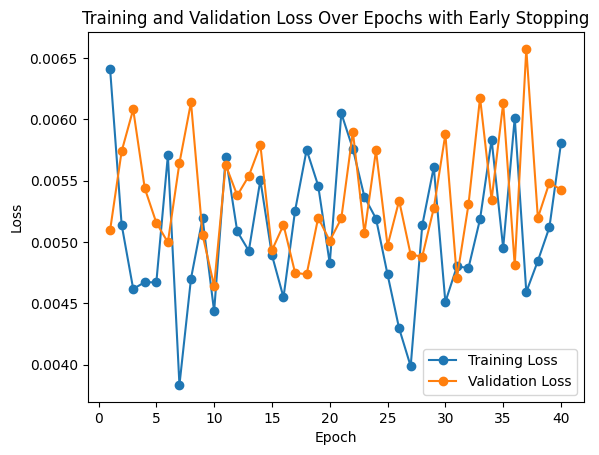

In [159]:
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs with Early Stopping')
plt.legend()
plt.show()

In [106]:
a = loss.cpu().detach().numpy()
a.item()

with torch.no_grad():
    y_val_pred = model(X_val)
    val_loss = criterion(y_val_pred, y_val)

0.0054346369579434395

In [78]:
next_state_values

tensor([0.0786, 0.0865, 0.0780, 0.0945, 0.0906, 0.0735, 0.0670, 0.0831, 0.0779,
        0.0743, 0.0932, 0.0966, 0.0979, 0.0759, 0.0688, 0.0601, 0.0768, 0.0802,
        0.0916, 0.0891, 0.0764, 0.0672, 0.0785, 0.0885, 0.0803, 0.0976, 0.0778,
        0.0830, 0.0853, 0.0861, 0.0619, 0.0700, 0.0787, 0.0794, 0.0803, 0.0805,
        0.0822, 0.0684, 0.0649, 0.0806, 0.0655, 0.0898, 0.0712, 0.0858, 0.0968,
        0.0776, 0.0968, 0.0745, 0.1011, 0.0909, 0.0841, 0.0735, 0.0943, 0.0901,
        0.0735, 0.0642, 0.1025, 0.0831, 0.0829, 0.0764, 0.0936, 0.0884, 0.0838,
        0.0732])

In [76]:
expected_state_action_values

tensor([0.0966, 0.0826, 0.0899, 0.0571, 0.0834, 0.0703, 0.0784, 0.0641, 0.0560,
        0.0697, 0.0986, 0.0978, 0.0920, 0.0846, 0.0618, 0.0897, 0.0691, 0.1126,
        0.0810, 0.0710, 0.0939, 0.0806, 0.0874, 0.1124, 0.0712, 0.0558, 0.0837,
        0.0852, 0.0792, 0.0893, 0.1023, 0.0862, 0.0903, 0.0976, 0.1037, 0.0842,
        0.0851, 0.0850, 0.0858, 0.1012, 0.1007, 0.0929, 0.0643, 0.0978, 0.0805,
        0.0683, 0.0784, 0.0839, 0.0931, 0.0669, 0.0864, 0.0881, 0.0874, 0.0892,
        0.1009, 0.0806, 0.0806, 0.1014, 0.0900, 0.0661, 0.0946, 0.0968, 0.0923,
        0.0672])

In [ ]:
# Compute a mask of non-final states and concatenate the batch elements
# (a final state would've been the one after which simulation ended)
next_state = torch.FloatTensor(batch.next_state).to(device)
non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, next_state)))
non_final_next_states = torch.cat([s for s in next_state if s is not None])

state_batch = torch.FloatTensor(batch.state).to(device)
action_batch = torch.LongTensor(torch.add(torch.tensor(batch.action), torch.tensor(1))).to(device)
reward_batch = torch.FloatTensor(batch.reward).to(device)

# Compute Q(s_t, a) - the model computes Q(s_t), then we select the
# columns of actions taken. These are the actions which would've been taken
# for each batch state according to policy_net
l = self.policy_net(state_batch).size(0)
state_action_values = self.policy_net(state_batch)[95:l:96].gather(1, action_batch.reshape((self.batch_size, 1)))
state_action_values = state_action_values.squeeze(-1)

# Compute V(s_{t+1}) for all next states.
# Expected values of actions for non_final_next_states are computed based
# on the "older" target_net; selecting their best reward with max(1)[0].
# This is merged based on the mask, such that we'll have either the expected
# state value or 0 in case the state was final.
next_state_values = torch.zeros(self.batch_size, device=device)
next_state_values[non_final_mask] = self.target_net(next_state)[95:l:96].max(1)[0].detach()
# Compute the expected Q values
expected_state_action_values = (next_state_values * self.gamma) + reward_batch

# Compute the loss
loss = torch.nn.MSELoss()(expected_state_action_values, state_action_values)

# Optimize the model

loss.backward()